In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./flowrec/utils/ppt.mplstyle')
from flowrec.utils.simulation import read_data_kolsol, kolsol_forcing_term

In [2]:
data,re,dt = read_data_kolsol('./local_data/kolmogorov/dim2_re34_k32_f4_dt1_grid128_14635.h5')

# Make test data 
strips of u only, with corresponding pressure point measurements

(10000, 20)


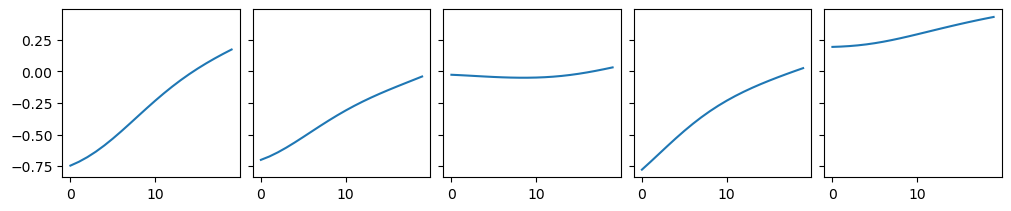

In [3]:
sp = data[:,:20,0,2]
print(sp.shape)
fig,axes = plt.subplots(1,5,figsize=(10,2),sharey=True)
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[i].plot(sp[t,:])

(10000, 20, 50)


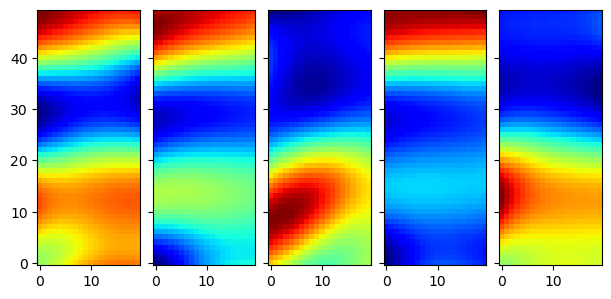

In [6]:
sv = data[:,:20,:50,0]
print(sv.shape)
fig,axes = plt.subplots(1,5,figsize=(6,3),sharey=True)
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[i].imshow(sv[t,:,:].T,origin='lower')

In [7]:
sp1 = data[:,40:60,0,2] # pressure without velocity plane
print(sp1.shape)
sv1 = data[:,40:60,:50,0]
print(sv1.shape)

(10000, 20)
(10000, 20, 50)


# First network
supervised network to recreate the strip

In [8]:
import jax
import jax.numpy as jnp
from flowrec.utils import system
import haiku as hk
from flowrec import losses
import optax
import flowrec.training_and_states as train

In [9]:
system.set_gpu(1,0.5)
key = jax.random.PRNGKey(10)

In [8]:
def forward1(x):
    layer1 = hk.Linear(128)
    layer2 = hk.Linear(20*50)
    out = layer1(x)
    out = jnp.tanh(out)
    out = layer2(out)
    return out.reshape((-1,20,50))
mdl1 = hk.transform(forward1)

In [9]:
params1 = mdl1.init(key,sp[:10,:])
# sp_s = 
# sv_s = 

/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [10]:
from functools import partial

In [11]:
op1 = optax.adamw(0.0005)
op1_state = op1.init(params1)
print(type(op1),type(op1_state))
update1 = train.generate_update_fn(mdl1.apply, op1, losses.loss_mse)
state1 = train.TrainingState(params=params1, opt_state=op1_state)
# state1 = train.TrainingState(params=state1.params, opt_state=op1_state)

<class 'optax._src.base.GradientTransformationExtraArgs'> <class 'tuple'>


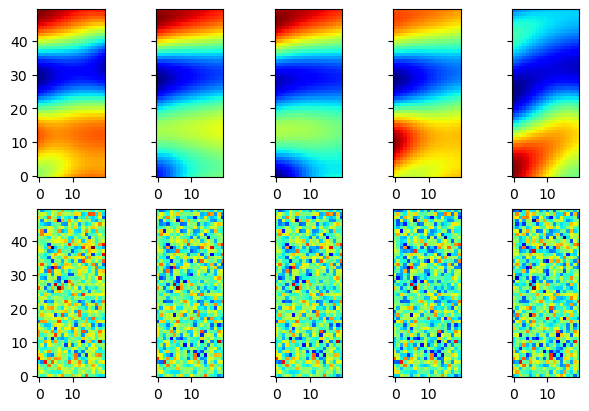

In [12]:
pred1 = mdl1.apply(state1.params, key, sp)
fig,axes = plt.subplots(2,5,figsize=(6,4),sharey=True)
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv[t,:,:].T,origin='lower')
    axes[1,i].imshow(pred1[t,:,:].T,origin='lower')
plt.show()

0 0.45003676
50 0.24596453
100 0.19837317
150 0.18101396
200 0.16930823
250 0.16449122
300 0.16198127
350 0.16013516
400 0.15849243
450 0.15690272
500 0.15530093
550 0.15364617
600 0.15189853
650 0.14998803
700 0.14779052
750 0.14521262
800 0.14232637
850 0.1392982
900 0.13624838
950 0.13328114
1000 0.13058347
1050 0.12832929
1100 0.1265141
1150 0.12503074
1200 0.12378458
1250 0.122710675
1300 0.12176514
1350 0.12091713
1400 0.120140366
1450 0.119419724
1500 0.1187436
1550 0.118102476
1600 0.11749142
1650 0.1169042
1700 0.11633027
1750 0.1157642
1800 0.11519365
1850 0.11461541
1900 0.11403438
1950 0.113440275
2000 0.11282309
2050 0.112174936
2100 0.111491464
2150 0.11076583
2200 0.10999256
2250 0.1091658
2300 0.108280875
2350 0.10732661
2400 0.106302015
2450 0.10520354
2500 0.104040615
2550 0.10281773
2600 0.10153515
2650 0.10020228
2700 0.09884447
2750 0.09749748
2800 0.09619209
2850 0.09495136
2900 0.0937883
2950 0.09269783
3000 0.091678195
3050 0.090728976
3100 0.08983189
3150 0.088

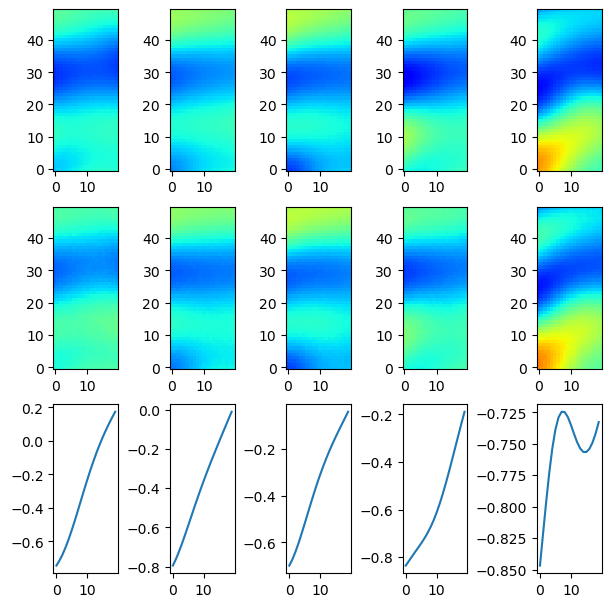

In [13]:
for i in range(10000):
    [key] = jax.random.split(key,1)
    l, state1 = update1(state1, key, sp, sv)
    if i%50 == 0:
        print(i, l)
sv_pred = mdl1.apply(state1.params, key, sp)
print(losses.relative_error(pred=sv_pred, true=sv))
fig,axes = plt.subplots(3,5,figsize=(6,6))
vmax = sv.max()
vmin = sv.min()
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv[t,:,:].T,origin='lower',vmax=vmax, vmin=vmin)
    axes[1,i].imshow(sv_pred[t,:,:].T,origin='lower',vmax=vmax, vmin=vmin)
    axes[2,i].plot(sp[t,:])
plt.show()

## Try applying to the second strip

1.371717


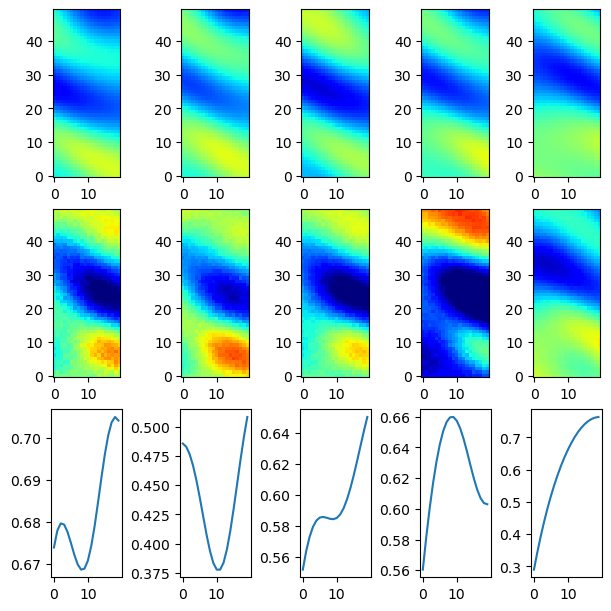

In [14]:
sv1_pred = mdl1.apply(state1.params, None, sp1)
print(losses.relative_error(pred=sv1_pred, true=sv1))
fig,axes = plt.subplots(3,5,figsize=(6,6))
vmax = sv1.max()
vmin = sv1.min()
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv1[t,:,:].T,origin='lower',vmax=vmax, vmin=vmin)
    axes[1,i].imshow(sv1_pred[t,:,:].T,origin='lower',vmax=vmax, vmin=vmin)
    axes[2,i].plot(sp1[t,:])
plt.show()

## Interpolate the in-between and combine strips

In [11]:
## interpolate to get the in-between pressure
from scipy.interpolate import CubicSpline
_xp = list(range(20))
_xp1 = list(range(40,60))
_xp.extend(_xp1)
xp = np.array(_xp)
nt = sp.shape[0]
sp_interp = []
for t in range(nt):
    fp = np.concatenate((sp[t,:],sp1[t,:]))
    spl = CubicSpline(x=xp, y=fp)
    sp_interp.append(spl(np.arange(20,40)))
sp_interp = np.array(sp_interp)
sp_interp_all = np.concatenate((sp,sp_interp,sp1), axis=1)

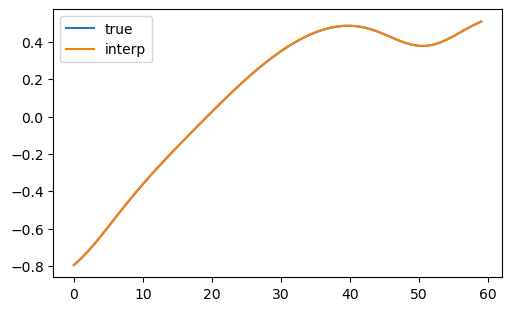

In [11]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(60),data[100,:60,0,2],label='true')
plt.plot(np.arange(60),sp_interp_all[100],label='interp')
plt.legend()
plt.show()

In [12]:
sv_interp = mdl1.apply(state1.params, None, sp_interp)
print(sv_interp.shape)

NameError: name 'mdl1' is not defined

In [13]:
sv_all = data[:,:60,:50,0]
sv_all_pred = np.concatenate((sv_pred,sv_interp,sv1_pred),axis=1)
print(sv_all_pred.shape)

NameError: name 'sv_pred' is not defined

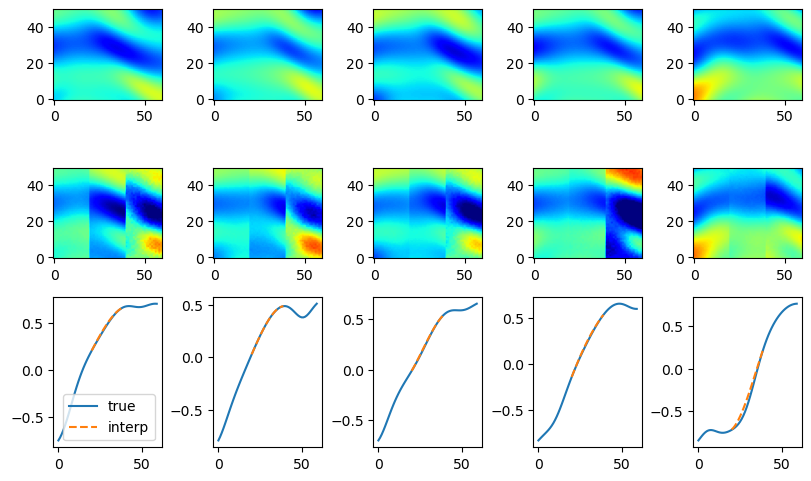

In [202]:
fig,axes = plt.subplots(3,5,figsize=(8,5))
vmax = sv1.max()
vmin = sv1.min()
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv_all[t,:,:].T,origin='lower',vmax=vmax, vmin=vmin)
    axes[1,i].imshow(sv_all_pred[t,:,:,0].T,origin='lower',vmax=vmax, vmin=vmin)
    axes[2,i].plot(np.arange(60),data[t,:60,0,2],label='true')
    axes[2,i].plot(np.arange(20,40),sp_interp[t,:],'--',label='interp')
axes[2,0].legend()
plt.show()

# Second network

In [24]:
sv2 = data[:,:60,:50,:]

In [223]:
def forward2(x):
    layer1 = hk.Conv2D(4,3)
    layer2 = hk.Conv2D(8,3)
    layer3 = hk.Conv2D(8,3)
    layer4 = hk.Conv2D(3,3)
    # out1 = layer1(x)
    # out1 = jnp.tanh(out1)
    # out2 = layer2(x)
    # out2 = jnp.tanh(out2)
    # out3 = layer3(x)
    # out3 = jnp.tanh(out3)
    # out = jnp.concatenate((out1,out2,out3),axis=-1)
    # out = layer4(out)
    x = layer1(x)
    x = jnp.tanh(x)
    x = layer2(x)
    x = jnp.tanh(x)
    x = layer3(x)
    x = jnp.tanh(x)
    out = layer4(x)
    return out
mdl2 = hk.transform(forward2)
sv_all_pred = sv_all_pred.reshape((-1,60,50,1))
params2 = mdl2.init(key,sv_all_pred[:10,...])

In [25]:
from flowrec.data import DataMetadata
datainfo = DataMetadata(
    re = 34,
    discretisation=[0.1, 2*np.pi/128, 2*np.pi/128],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()

In [26]:
f = kolsol_forcing_term(4, 128, 2)[:,:,:60,:50]
f.shape

(2, 1, 60, 50)

In [17]:
# losses.divergence(data[:,:60,:50,:2],datainfo)
losses.momentum_loss(data[:100,:60,:50,:],datainfo,forcing=f)

Array(8.346314e-06, dtype=float32)

In [18]:
sv.shape

(10000, 20, 50)

In [228]:
def myloss(apply_fn, params, rng, x, y):
    pred = apply_fn(params, rng, x)
    # lu = losses.mse(pred=pred[:,:20,:,0], true=y['sv'])
    # lb1 = losses.mse(pred=pred[:,:20,0,2], true=y['sp']) + losses.mse(pred=pred[:,40:,0,2],true=y['sp1'])
    # lb2 = losses.mse(pred=pred[:,:,0,1], true=y['v'])
    pred = pred.at[:,:20,:,0].set(y['sv'])
    pred = pred.at[:,:20,0,2].set(y['sp'])
    pred = pred.at[:,40:,0,2].set(y['sp1'])
    pred = pred.at[:,:,::2,1].set(y['v'][:,:,::2,1])
    _ld = losses.divergence(pred[...,:2],datainfo)
    _lm = losses.momentum_loss(pred,datainfo,forcing=f)
    lp = _ld + _lm
    # return 50*lu+80*lb1+80*lb2+10*lp
    return lp

In [229]:
op2 = optax.adamw(0.001)
op2_state = op2.init(params2)
state2 = train.TrainingState(opt_state=op2_state, params=params2)
# state2 = train.TrainingState(opt_state=op2_state, params=state2.params)

In [230]:
# update2 = train.generate_update_fn(mdl2.apply, op2, myloss)
# _ = update2(state2, key, sv_all_pred[:10,...], {'sv':sv[:10,...],'sp':sp[:10,...],'sp1':sp1[:10,...],'v':sv2[:10,...]})
update2 = train.generate_update_fn(mdl2.apply, op2, losses.loss_mse)
_ = update2(state2, key, sv_all_pred[:10,...], sv2[:10,...])
sv2_pred = mdl2.apply(state2.params, key, sv_all_pred)
print(losses.relative_error(pred=sv2_pred, true=sv2))

0.9973847


In [231]:
nperbatch = int(nt/10)
nperbatch

1000

In [235]:
for i in range(500):
    [key] = jax.random.split(key,1)
    lb = []
    for b in range(10):
        # l, state2 = update2(state2, key, sv_all_pred[b*nperbatch:(b+1)*nperbatch,...], {'sv':sv[b*nperbatch:(b+1)*nperbatch,...], 'sp':sp[b*nperbatch:(b+1)*nperbatch,...], 'sp1': sp1[b*nperbatch:(b+1)*nperbatch,...], 'v': sv2[b*nperbatch:(b+1)*nperbatch,...]})
        l, state2 = update2(state2, key, sv_all_pred[b*nperbatch:(b+1)*nperbatch,...], sv2[b*nperbatch:(b+1)*nperbatch,...])
        lb.append(l)
    if i%50 == 0:
        print(i, np.mean(lb))
sv2_pred = mdl2.apply(state2.params, key, sv_all_pred)
print(losses.relative_error(pred=sv2_pred, true=sv2))

0 0.31396538
50 0.312268
100 0.3108666
150 0.3096586
200 0.30857477
250 0.30757326
300 0.30663195
350 0.30574113
400 0.3048975
450 0.30409932
0.77387613


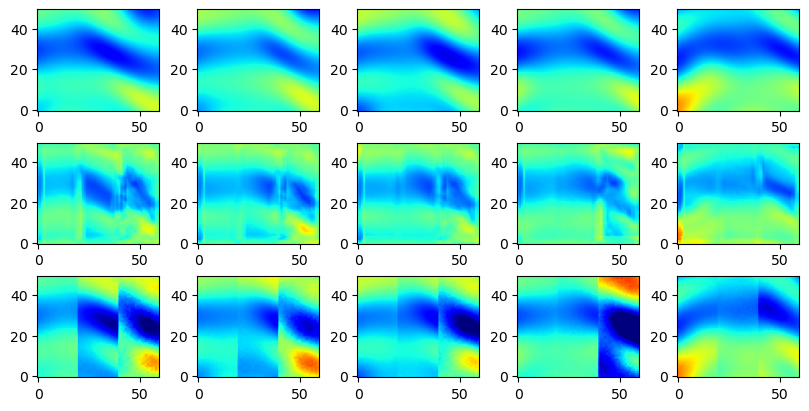

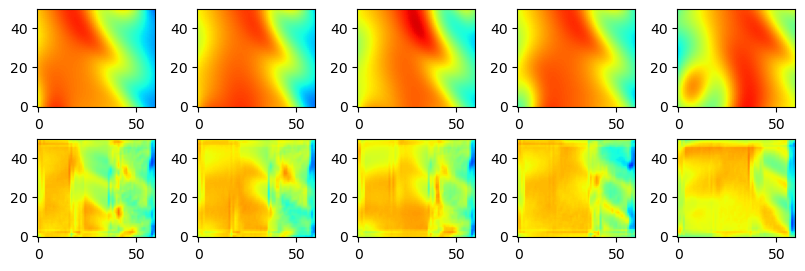

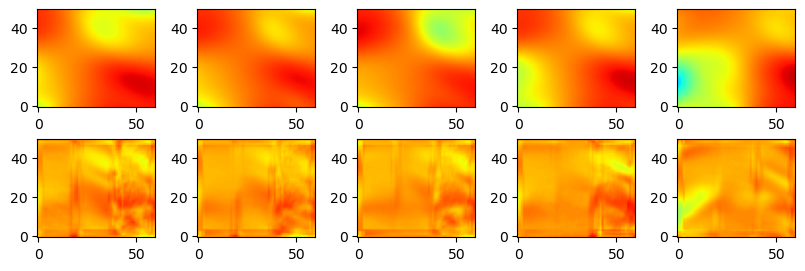

In [236]:
vmax = np.max(sv2,axis=(0,1,2))
vmin = np.min(sv2,axis=(0,1,2))
fig,axes = plt.subplots(3,5,figsize=(8,4))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[1,i].imshow(sv2_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[2,i].imshow(sv_all_pred[t,:,:,0].T,origin='lower',vmax=vmax[0],vmin=vmin[0])
plt.show()
fig,axes = plt.subplots(2,5,figsize=(8,2.6))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[1,i].imshow(sv2_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
plt.show()
fig,axes = plt.subplots(2,5,figsize=(8,2.6))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[1,i].imshow(sv2_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])

# Network 3 
try if data driven works

linear layers to 1 channel, then cnn to create different velocity components

this works

In [253]:
def forward3(x):
    layer1 = hk.Linear(128)
    layer2 = hk.Linear(60*50)
    layer3 = hk.Conv2D(8,3)
    layer4 = hk.Conv2D(3,3)
    x = layer1(x)
    x = jnp.tanh(x)
    x = layer2(x)
    x = x.reshape((-1,60,50,1))
    x = jnp.tanh(x)
    x = layer3(x)
    x = jnp.tanh(x)
    out = layer4(x)
    return out
mdl3 = hk.transform(forward3)
params3 = mdl3.init(key, sp_interp_all[:10,...])
mdl3.apply(params3,None,sp_interp_all[:10,...]).shape

/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


(10, 60, 50, 3)

In [254]:
op3 = optax.adamw(0.001)
op3_state = op3.init(params3)
state3 = train.TrainingState(opt_state=op3_state, params=params3)

In [255]:
# update3 = train.generate_update_fn(mdl3.apply, op3, myloss)
# _ = update3(state3, key, sv_all_pred[:10,...], {'sv':sv[:10,...],'sp':sp[:10,...],'sp1':sp1[:10,...],'v':sv3[:10,...]})
update3 = train.generate_update_fn(mdl3.apply, op3, losses.loss_mse)
_ = update3(state3, key, sp_interp_all[:10,...], sv2[:10,...])
sv3_pred = mdl3.apply(state3.params, key, sp_interp_all)
print(losses.relative_error(pred=sv3_pred, true=sv2))

1.0275558


In [256]:
for i in range(500):
    [key] = jax.random.split(key,1)
    lb = []
    for b in range(10):
        # l, state2 = update2(state2, key, sv_all_pred[b*nperbatch:(b+1)*nperbatch,...], {'sv':sv[b*nperbatch:(b+1)*nperbatch,...], 'sp':sp[b*nperbatch:(b+1)*nperbatch,...], 'sp1': sp1[b*nperbatch:(b+1)*nperbatch,...], 'v': sv2[b*nperbatch:(b+1)*nperbatch,...]})
        l, state3 = update3(state3, key, sp_interp_all[b*nperbatch:(b+1)*nperbatch,...], sv2[b*nperbatch:(b+1)*nperbatch,...])
        lb.append(l)
    if i%50 == 0:
        print(i, np.mean(lb))
sv3_pred = mdl3.apply(state3.params, key, sp_interp_all)
print(losses.relative_error(pred=sv3_pred, true=sv2))

0 0.4992702
50 0.23575401
100 0.18805273
150 0.14242816
200 0.11981324
250 0.102838755
300 0.09529677
350 0.08751985
400 0.08308422
450 0.07487521
0.38620052


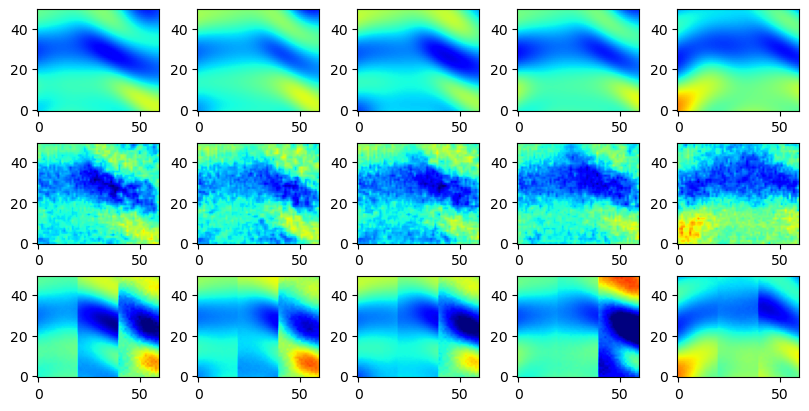

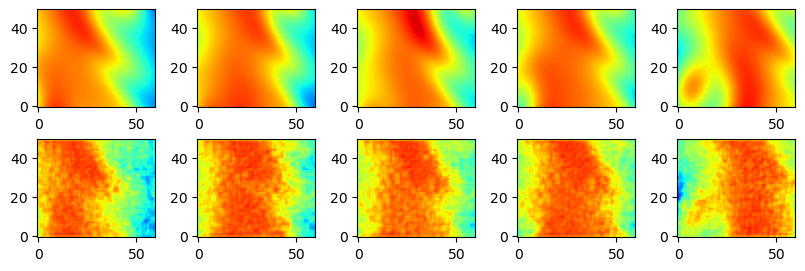

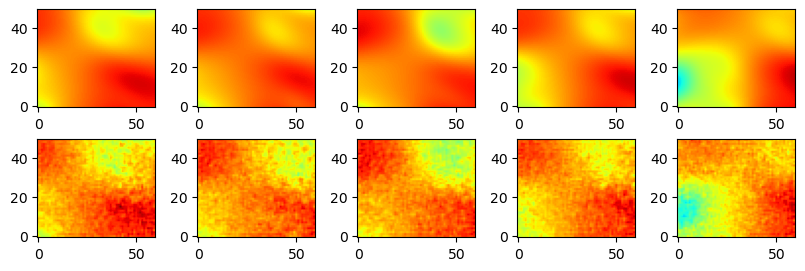

In [257]:
vmax = np.max(sv2,axis=(0,1,2))
vmin = np.min(sv2,axis=(0,1,2))
fig,axes = plt.subplots(3,5,figsize=(8,4))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[1,i].imshow(sv3_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    # axes[2,i].imshow(sv_all_pred[t,:,:,0].T,origin='lower',vmax=vmax[0],vmin=vmin[0])
    axes[2,i].imshow(sp_interp_all[t,:])
plt.show()
fig,axes = plt.subplots(2,5,figsize=(8,2.6))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[1,i].imshow(sv3_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
plt.show()
fig,axes = plt.subplots(2,5,figsize=(8,2.6))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[1,i].imshow(sv3_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])

# Network 4 single large network 
with pre-trained mdl1

In [259]:
sv_pred.shape

(10000, 20, 50)

In [27]:
from flowrec.models.feedforward import MLP

In [347]:
def forward4(x):
    mdl = MLP([128,20*50],name='mdl1',activation=jnp.tanh)
    x1 = mdl(x[:,:20],TRAINING=True).reshape((-1,20,50,1))
    x2 = mdl(x[:,20:40],TRAINING=True).reshape((-1,20,50,1))
    x3 = mdl(x[:,40:],TRAINING=True).reshape((-1,20,50,1))
    x4 = jnp.concatenate((x1,x2,x3),axis=1)

    cnn1 = hk.Conv2D(12,3)
    cnn2 = hk.Conv2D(8,3)
    cnn3 = hk.Conv2D(3,3)
    x4 = cnn1(x4)
    jnp.tanh(x4)
    x4 = cnn2(x4)
    jnp.tanh(x4)
    out = cnn3(x4)
    return x1, out
mdl4 = hk.transform(forward4)
params4 = mdl4.init(key, sp_interp_all[:10])
y1,y2 = mdl4.apply(params4, None, sp_interp_all[:10])
print(y1.shape, y2.shape)

(10, 20, 50, 1) (10, 60, 50, 3)


/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [348]:
print(jax.tree_map(lambda l: print(l.shape), params4))
print(jax.tree_map(lambda l: print(l.shape), params1))

(12,)
(3, 3, 1, 12)
(8,)
(3, 3, 12, 8)
(3,)
(3, 3, 8, 3)
(128,)
(20, 128)
(1000,)
(128, 1000)
{'conv2_d': {'b': None, 'w': None}, 'conv2_d_1': {'b': None, 'w': None}, 'conv2_d_2': {'b': None, 'w': None}, 'mdl1/~/linear_0': {'b': None, 'w': None}, 'mdl1/~/linear_1': {'b': None, 'w': None}}
(128,)
(20, 128)
(1000,)
(128, 1000)
{'linear': {'b': None, 'w': None}, 'linear_1': {'b': None, 'w': None}}


In [349]:
params1_trained = {
    'mdl1/~/linear_0': state1.params['linear'],    # Rename the first layer
    'mdl1/~/linear_1': state1.params['linear_1'],  # Rename the second layer
}
params4_conv = {key:params4[key] for key in params4 if 'conv2' in key}
print(jax.tree_map(lambda l: print(l.shape), params4_conv))
params4_pretrained = {**params4_conv, **params1_trained}
# print(jax.tree_map(lambda l: print(l.shape), params4_pretrained))
# print(jax.tree_map(lambda l: print(l.shape), params4))

y1,sv4_pred = mdl4.apply(params4_pretrained, None, sp_interp_all[:10])
print(y1.shape,sv4_pred.shape)

(12,)
(3, 3, 1, 12)
(8,)
(3, 3, 12, 8)
(3,)
(3, 3, 8, 3)
{'conv2_d': {'b': None, 'w': None}, 'conv2_d_1': {'b': None, 'w': None}, 'conv2_d_2': {'b': None, 'w': None}}
(10, 20, 50, 1) (10, 60, 50, 3)


In [350]:
op4 = optax.adamw(0.001)
op4_state = op4.init(params4_pretrained)
state4 = train.TrainingState(opt_state=op4_state, params=params4_pretrained)

In [351]:
def myloss4(apply_fn, params, rng, x, y):
    out1, out2 = apply_fn(params, rng, x)
    # loss1 = losses.mse(out1, y[:,:20,:,[0]])
    loss2 = losses.mse(out2, y)
    return loss2

In [353]:
# update2 = train.generate_update_fn(mdl2.apply, op2, myloss)
# _ = update2(state2, key, sv_all_pred[:10,...], {'sv':sv[:10,...],'sp':sp[:10,...],'sp1':sp1[:10,...],'v':sv2[:10,...]})
update4 = train.generate_update_fn(mdl4.apply, op4, myloss4)
_ = update4(state4, key, sp_interp_all[:10,...], sv2[:10,...])
sv4_mid, sv4_pred = mdl4.apply(state4.params, key, sp_interp_all)
print(losses.relative_error(pred=sv4_pred, true=sv2))

1.1155344


In [354]:
nperbatch = int(nt/10)
nperbatch

1000

In [358]:
for i in range(500):
    [key] = jax.random.split(key,1)
    lb = []
    for b in range(10):
        l, state4 = update4(state4, key, sp_interp_all[b*nperbatch:(b+1)*nperbatch,...], sv2[b*nperbatch:(b+1)*nperbatch,...])
        lb.append(l)
    if i%50 == 0:
        print(i, np.mean(lb))
sv4_mid, sv4_pred = mdl4.apply(state4.params, key, sp_interp_all)
print(losses.relative_error(pred=sv4_pred, true=sv2))

0 0.22258809
50 0.22641048
100 0.2233611
150 0.22008774
200 0.21989968
250 0.2206059
300 0.22210398
350 0.22368324
400 0.22417338
450 0.22929725
0.6705372


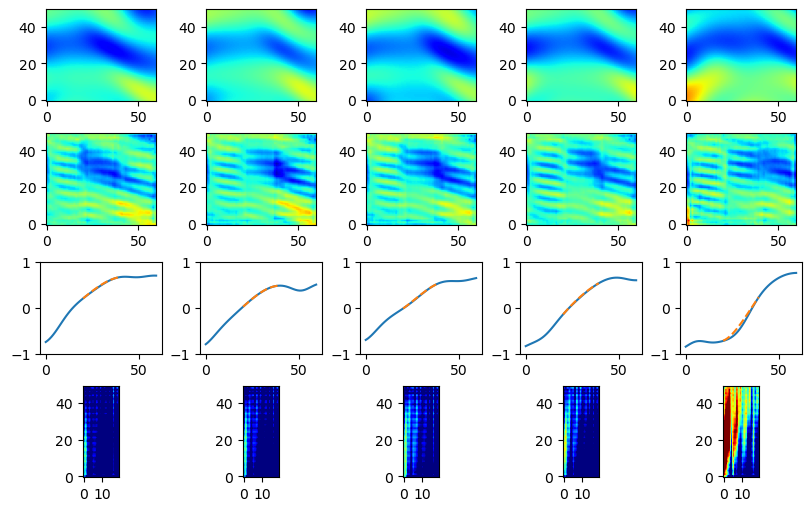

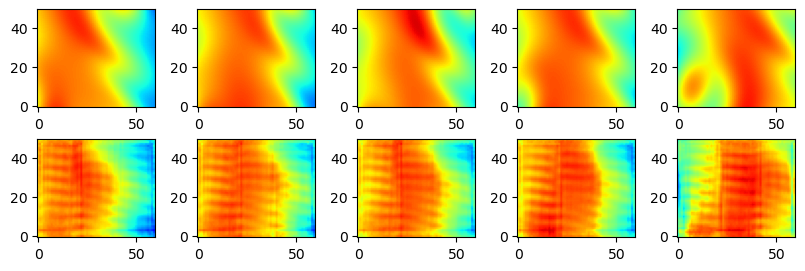

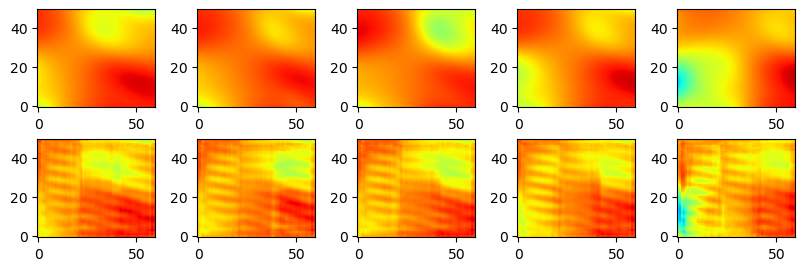

In [359]:
vmax = np.max(sv2,axis=(0,1,2))
vmin = np.min(sv2,axis=(0,1,2))
fig,axes = plt.subplots(4,5,figsize=(8,5))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[1,i].imshow(sv4_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[2,i].plot(np.arange(60),data[t,:60,0,2])
    axes[2,i].plot(np.arange(20,40),sp_interp[t,:],'--')
    axes[2,i].set_ylim(-1,1)
    axes[3,i].imshow(sv4_mid[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
plt.show()
fig,axes = plt.subplots(2,5,figsize=(8,2.6))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[1,i].imshow(sv4_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
plt.show()
fig,axes = plt.subplots(2,5,figsize=(8,2.6))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[1,i].imshow(sv4_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])

# Network 5
train everything from beginning, but parameters are shared for the strips

In [507]:
def forward5(x):
    x1 = x[:,:20]
    x2 = x[:,20:40]
    x3 = x[:,40:]
    mdl = MLP([128,20*50],name='mdl1',activation=jnp.tanh)
    x1 = mdl(x[:,:20],TRAINING=True).reshape((-1,20,50,1))
    x2 = mdl(x[:,20:40],TRAINING=True).reshape((-1,20,50,1))
    x3 = mdl(x[:,40:],TRAINING=True).reshape((-1,20,50,1))
    cnn1 = hk.Conv2D(12,3)
    cnn2 = hk.Conv2D(8,3)
    cnn3 = hk.Conv2D(3,3)
    x1 = cnn1(x1)
    x1 = jnp.tanh(x1)
    x1 = cnn2(x1)
    x1 = jnp.tanh(x1)
    x1 = cnn3(x1)
    x2 = cnn1(x2)
    x2 = jnp.tanh(x2)
    x2 = cnn2(x2)
    x2 = jnp.tanh(x2)
    x2 = cnn3(x2)
    x3 = cnn1(x3)
    x3 = jnp.tanh(x3)
    x3 = cnn2(x3)
    x3 = jnp.tanh(x3)
    x3 = cnn3(x3)
    out= jnp.concatenate((x1,x2,x3),axis=1)
    return x1, out
mdl5 = hk.transform(forward5)
params5 = mdl5.init(key, sp_interp_all[:10])
y1,y2 = mdl5.apply(params5, None, sp_interp_all[:10])
print(y1.shape, y2.shape)

(10, 20, 50, 3) (10, 60, 50, 3)


In [508]:
op5 = optax.adamw(0.001)
op5_state = op5.init(params5)
state5 = train.TrainingState(opt_state=op5_state, params=params5)

In [509]:
def myloss5(apply_fn, params, rng, x, y):
    out1, out2 = apply_fn(params, rng, x)
    # loss1 = losses.mse(out1, y[:,:20,:,[0]])
    loss2 = losses.mse(out2, y)
    return loss2

In [510]:
print(jax.tree_map(lambda l: print(l.shape), params5))

(12,)
(3, 3, 1, 12)
(8,)
(3, 3, 12, 8)
(3,)
(3, 3, 8, 3)
(128,)
(20, 128)
(1000,)
(128, 1000)
{'conv2_d': {'b': None, 'w': None}, 'conv2_d_1': {'b': None, 'w': None}, 'conv2_d_2': {'b': None, 'w': None}, 'mdl1/~/linear_0': {'b': None, 'w': None}, 'mdl1/~/linear_1': {'b': None, 'w': None}}


In [505]:
# update2 = train.generate_update_fn(mdl2.apply, op2, myloss)
# _ = update2(state2, key, sv_all_pred[:10,...], {'sv':sv[:10,...],'sp':sp[:10,...],'sp1':sp1[:10,...],'v':sv2[:10,...]})
update5 = train.generate_update_fn(mdl5.apply, op5, myloss5)
_ = update5(state5, key, sp_interp_all[:10,...], sv2[:10,...])
sv5_mid, sv5_pred = mdl5.apply(state5.params, key, sp_interp_all)
print(losses.relative_error(pred=sv5_pred, true=sv2))

1.0249548


In [506]:
nperbatch = int(nt/10)
for i in range(2000):
    [key] = jax.random.split(key,1)
    lb = []
    for b in range(10):
        l, state5 = update5(state5, key, sp_interp_all[b*nperbatch:(b+1)*nperbatch,...], sv2[b*nperbatch:(b+1)*nperbatch,...])
        lb.append(l)
    if i%50 == 0:
        print(i, np.mean(lb))
sv5_mid, sv5_pred = mdl5.apply(state5.params, key, sp_interp_all)
print(losses.relative_error(pred=sv5_pred, true=sv2))

0 0.49818516
50 0.27847487


KeyboardInterrupt: 

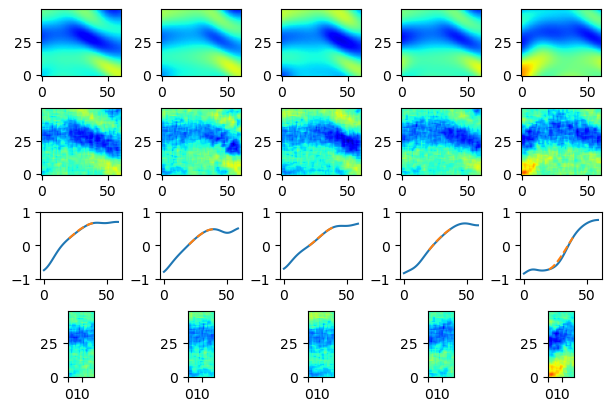

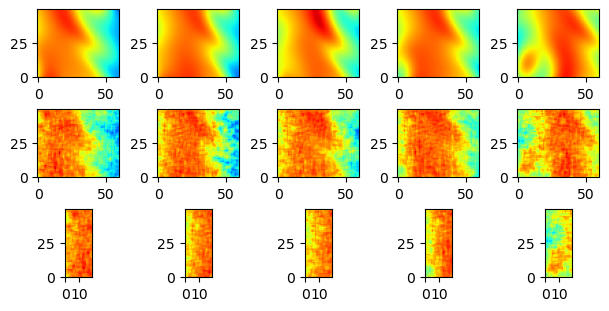

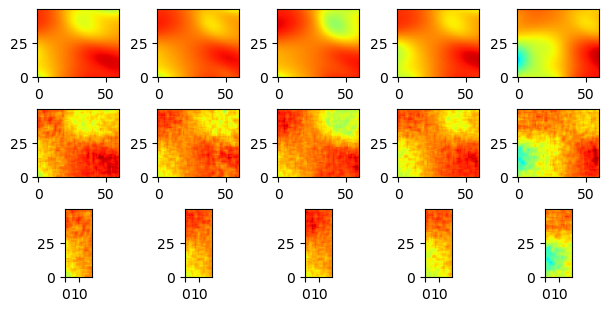

In [374]:
vmax = np.max(sv2,axis=(0,1,2))
vmin = np.min(sv2,axis=(0,1,2))
fig,axes = plt.subplots(4,5,figsize=(6,4))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[1,i].imshow(sv5_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[2,i].plot(np.arange(60),data[t,:60,0,2])
    axes[2,i].plot(np.arange(20,40),sp_interp[t,:],'--')
    axes[2,i].set_ylim(-1,1)
    axes[3,i].imshow(sv5_mid[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
plt.show()
fig,axes = plt.subplots(3,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[1,i].imshow(sv5_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[2,i].imshow(sv5_mid[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
plt.show()
fig,axes = plt.subplots(3,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[1,i].imshow(sv5_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[2,i].imshow(sv5_mid[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])

## Now with less data and physics

In [790]:
def forward5(x):
    x1 = x[:,:20]
    x2 = x[:,20:40]
    x3 = x[:,40:]
    mdl = MLP([128,20*50],name='mdl1',activation=jnp.tanh)
    x1 = mdl(x[:,:20],TRAINING=True).reshape((-1,20,50,1))
    x2 = mdl(x[:,20:40],TRAINING=True).reshape((-1,20,50,1))
    x3 = mdl(x[:,40:],TRAINING=True).reshape((-1,20,50,1))
    cnn1 = hk.Conv2D(12,3)
    cnn2 = hk.Conv2D(8,3)
    cnn3 = hk.Conv2D(4,3)
    cnn4 = hk.Conv2D(3,3)
    v_resize = jax.vmap(partial(jax.image.resize,method='linear'),(-1,None),-1)
    vv_resize = jax.vmap(v_resize,(0,None),0)
    # mask = jnp.concatenate((jnp.zeros((1,20,50,2)),-1*jnp.ones((1,20,50,1))),axis=-1)
    
    x1_0 = jnp.copy(x1)
    x1 = vv_resize(x1,(10,25))
    x1 = cnn1(x1)
    x1 = jnp.tanh(x1)
    x1 = vv_resize(x1,(20,25))
    x1 = cnn2(x1)
    x1 = jnp.tanh(x1)
    x1 = vv_resize(x1,(20,50))
    x1 = jnp.concatenate((x1_0,x1),axis=-1)
    x1 = cnn3(x1)
    x1 = jnp.tanh(x1)
    x1 = cnn4(x1)
    # x1 = x1 + mask
    
    x2_0 = jnp.copy(x2)
    x2 = vv_resize(x2,(10,25))
    x2 = cnn1(x2)
    x2 = jnp.tanh(x2)
    x2 = vv_resize(x2,(20,25))
    x2 = cnn2(x2)
    x2 = jnp.tanh(x2)
    x2 = vv_resize(x2,(20,50))
    x2 = jnp.concatenate((x2_0,x2),axis=-1)
    x2 = cnn3(x2)
    x2 = jnp.tanh(x2)
    x2 = cnn4(x2)
    # x2 = x2 + mask
    
    x3_0 = jnp.copy(x3)
    x3 = vv_resize(x3,(10,25))
    x3 = cnn1(x3)
    x3 = jnp.tanh(x3)
    x3 = vv_resize(x3,(20,25))
    x3 = cnn2(x3)
    x3 = jnp.tanh(x3)
    x3 = vv_resize(x3,(20,50))
    x3 = jnp.concatenate((x3_0,x3),axis=-1)
    x3 = cnn3(x3)
    x3 = jnp.tanh(x3)
    x3 = cnn4(x3)
    # x3 = x3 + mask
    
    out= jnp.concatenate((x1,x2,x3),axis=1)
    return x1, out
mdl5 = hk.transform(forward5)

In [791]:
losses.momentum_loss(sv2,datainfo,forcing=f)

Array(1.709469e-05, dtype=float32)

In [792]:
params5_1 = mdl5.init(key, sp_interp_all[:10,...])
op5_1 = optax.adamw(0.001)
op5_1_state = op5_1.init(params5_1)
state5_1 = train.TrainingState(opt_state=op5_1_state, params=params5_1)
print(jax.tree_map(lambda l: print(l.shape), params5_1))

(12,)
(3, 3, 1, 12)
(8,)
(3, 3, 12, 8)
(4,)
(3, 3, 9, 4)
(3,)
(3, 3, 4, 3)
(128,)
(20, 128)
(1000,)
(128, 1000)
{'conv2_d': {'b': None, 'w': None}, 'conv2_d_1': {'b': None, 'w': None}, 'conv2_d_2': {'b': None, 'w': None}, 'conv2_d_3': {'b': None, 'w': None}, 'mdl1/~/linear_0': {'b': None, 'w': None}, 'mdl1/~/linear_1': {'b': None, 'w': None}}


/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [794]:
# def myloss5_1(apply_fn, params, rng, x, y):
#     out1, out2 = apply_fn(params, rng, x)
#     lplane = losses.mse(out1[:,:,:,0], y[:,:20,:,0]) # plane u
#     lbp = losses.mse(out2[:,:20,0,2],y[:,:20,0,2]) + losses.mse(out2[:,40:,0,2],y[:,40:,0,2]) # boundary pressure
#     _ld = losses.divergence(out2[...,:2],datainfo)
#     _lm = losses.momentum_loss(out2,datainfo,forcing=f)
#     lp = _ld + _lm
#     a = 0.9
#     b = 0.03
#     return a*lplane+b*lbp+(1-a-b)*lp, {'plane':lplane, 'boundary':lbp, 'physics':lp}

def myloss5_1(apply_fn, params, rng, x, y):
    out1, out2 = apply_fn(params, rng, x)
    lplane = losses.mse(out1[:,:,:,0], y[:,:20,:,0])
    lplane = lplane + losses.mse(out1[:,:,:,1], y[:,:20,:,1])
    # out2 = out2.at[:,:20,:,0].set(y[:,:20,:,0]) # u1
    # out2 = out2.at[:,:20,:,1].set(y[:,:20,:,1]) # u2 at the plane
    # out2 = out2.at[:,:20,:,2].set(y[:,:20,:,2]) # pressure at the plane
    out2 = out2.at[:,::2,::2,:].set(y[:,::2,::2,:])
    # out2 = out2.at[:,:20,0,2].set(y[:,:20,0,2]) # boundary pressure
    # out2 = out2.at[:,40:,0,2].set(y[:,40:,0,2]) # boundary pressure
    _ld = losses.divergence(out2[...,:2],datainfo)
    _lm = losses.momentum_loss(out2,datainfo,forcing=f)
    lp = _ld + _lm
    a = 0.0
    return a*lplane + (1-a)*lp, {'plane':lplane, 'physics':lp}

In [779]:
op5_1 = optax.adamw(0.0008)
op5_1_state = op5_1.init(state5_1.params)
state5_1 = train.TrainingState(params=state5_1.params, opt_state=op5_1_state)

In [795]:
# update5_1 = train.generate_update_fn(mdl5.apply, op5_1, myloss5_1)
# _ = update5_1(state5_1, key, sp_interp_all[:10,...], sv2[:10,...])
update5_1 = train.generate_update_fn(mdl5.apply, op5_1, myloss5_1, kwargs_value_and_grad={'has_aux': True})
(l,l_dict),_ = update5_1(state5_1, key, sp_interp_all[:10,...], sv2[:10,...])
sv5_1_mid, sv5_1_pred = mdl5.apply(state5_1.params, key, sp_interp_all)
print(losses.relative_error(pred=sv5_1_pred, true=sv2))
print(l,l_dict)

1.0049164
2237.921 {'physics': Array(2237.921, dtype=float32), 'plane': Array(1.5666784, dtype=float32)}


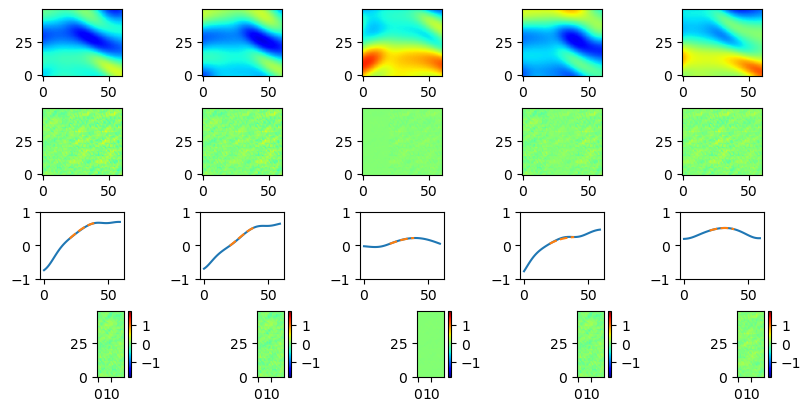

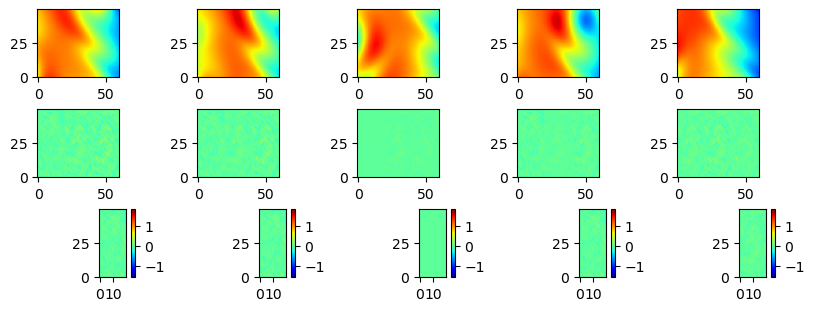

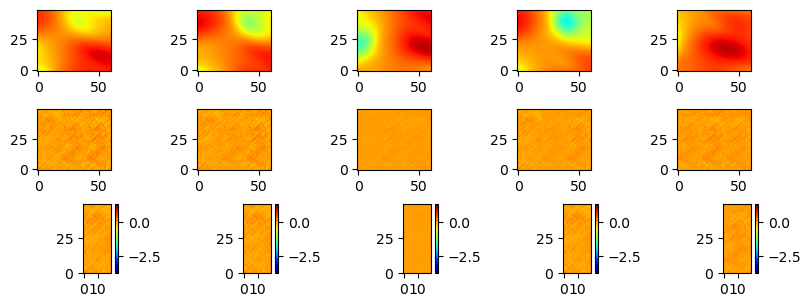

In [796]:
vmax = np.max(sv2,axis=(0,1,2))
vmin = np.min(sv2,axis=(0,1,2))
fig,axes = plt.subplots(4,5,figsize=(8,4))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[1,i].imshow(sv5_1_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[2,i].plot(np.arange(60),data[t,:60,0,2])
    axes[2,i].plot(np.arange(20,40),sp_interp[t,:],'--')
    axes[2,i].set_ylim(-1,1)
    im = axes[3,i].imshow(sv5_1_mid[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    plt.colorbar(im)
plt.show()
fig,axes = plt.subplots(3,5,figsize=(8,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[1,i].imshow(sv5_1_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    im = axes[2,i].imshow(sv5_1_mid[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    plt.colorbar(im)
plt.show()
fig,axes = plt.subplots(3,5,figsize=(8,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[1,i].imshow(sv5_1_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    im = axes[2,i].imshow(sv5_1_mid[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    plt.colorbar(im)

In [797]:
hist = []

In [798]:
nb_batches = 10
nperbatch = int(nt/nb_batches)
print(nperbatch)

1000


In [802]:
bestloss = jnp.inf
print(nperbatch)
for i in range(500):
    [key] = jax.random.split(key,1)
    lb = []
    lb_dict = []
    for b in range(nb_batches):
        (l,l_dict), state5_1 = update5_1(state5_1, key, sp_interp_all[b*nperbatch:(b+1)*nperbatch,...], sv2[b*nperbatch:(b+1)*nperbatch,...])
        # l, state5_1 = update5_1(state5_1, key, sp_interp_all[b*nperbatch:(b+1)*nperbatch,...], sv2[b*nperbatch:(b+1)*nperbatch,...])
        lb.append(l)
        lb_dict.append(l_dict)
        hist.append(np.mean(lb))
    if np.mean(lb) < bestloss:
        bestloss = np.mean(lb)
        beststate = state5_1
    if i%50 == 0:
        print(i, np.mean(lb),lb_dict[5])
sv5_1_mid, sv5_1_pred = mdl5.apply(beststate.params, key, sp_interp_all)
print(losses.relative_error(pred=sv5_1_pred, true=sv2))
plt.figure(figsize=(7,3))
plt.plot(hist[::10])
plt.show()

1000
0 851.8841 {'physics': Array(2003.3805, dtype=float32), 'plane': Array(0.4717906, dtype=float32)}
50 843.38513 {'physics': Array(1992.5403, dtype=float32), 'plane': Array(0.4791401, dtype=float32)}
100 835.7197 {'physics': Array(1981.1466, dtype=float32), 'plane': Array(0.4849282, dtype=float32)}
150 828.69543 {'physics': Array(1970.9119, dtype=float32), 'plane': Array(0.48860544, dtype=float32)}


KeyboardInterrupt: 

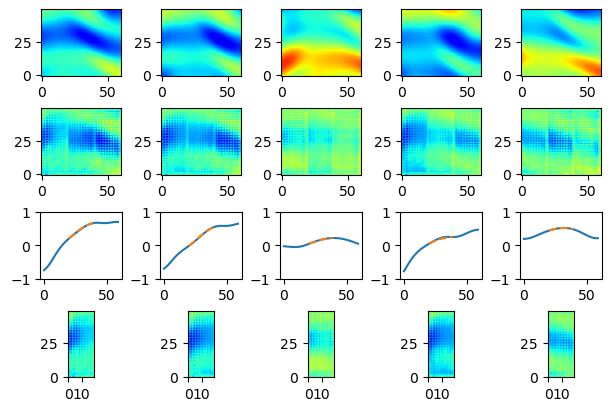

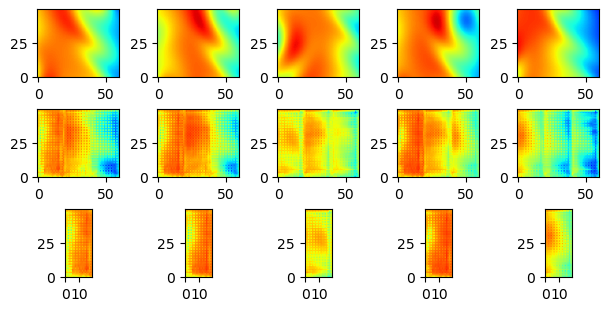

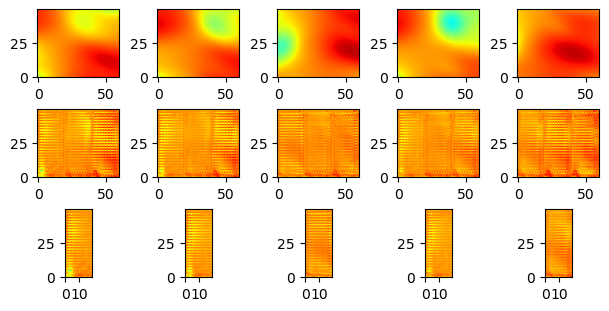

In [800]:
vmax = np.max(sv2,axis=(0,1,2))
vmin = np.min(sv2,axis=(0,1,2))
fig,axes = plt.subplots(4,5,figsize=(6,4))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[1,i].imshow(sv5_1_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    axes[2,i].plot(np.arange(60),data[t,:60,0,2])
    axes[2,i].plot(np.arange(20,40),sp_interp[t,:],'--')
    axes[2,i].set_ylim(-1,1)
    axes[3,i].imshow(sv5_1_mid[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
plt.show()
fig,axes = plt.subplots(3,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[1,i].imshow(sv5_1_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    axes[2,i].imshow(sv5_1_mid[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
plt.show()
fig,axes = plt.subplots(3,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    axes[0,i].imshow(sv2[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[1,i].imshow(sv5_1_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    axes[2,i].imshow(sv5_1_mid[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])

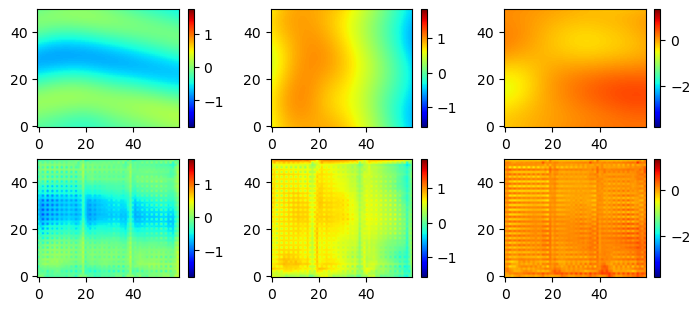

In [801]:
fig,axes = plt.subplots(2,3,figsize=(7,3))
for i in range(3):
    im0 = axes[0,i].imshow(np.mean(sv2[...,i],axis=0).T, vmax=vmax[i], vmin=vmin[i], origin='lower')
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(np.mean(sv5_1_pred[...,i], axis=0).T, vmax=vmax[i], vmin=vmin[i], origin='lower')
    plt.colorbar(im1)
plt.show()

## Pre-train velocities

In [80]:
from flowrec.models.cnn import MLPWithCNN

def forward5_2(x):
    # mdl = MLPWithCNN(
    #     [128,20*50],
    #     (20,50,1),
    #     [8,2],
    #     ((3,3),),
    #     name='pretrain'
    # )
    mdl = MLP(
        [128,20*50, 20*50*2],
        activation=jnp.tanh,
        name='pretrain',
    )
    return mdl(x,TRAINING=True).reshape((-1,20,50,2))
mdl5_2 = hk.transform(forward5_2)
params5_2 =mdl5_2.init(key,sp[:10,...])
print(jax.tree_map(lambda l: print(l.shape), params5_2))
print(mdl5_2.apply(params5_2, None, sp[:10,...]).shape)

(128,)
(20, 128)
(1000,)
(128, 1000)
(2000,)
(1000, 2000)
{'pretrain/~/linear_0': {'b': None, 'w': None}, 'pretrain/~/linear_1': {'b': None, 'w': None}, 'pretrain/~/linear_2': {'b': None, 'w': None}}
(10, 20, 50, 2)


/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [193]:
sv5 = data[:,:20,:50,:2]
sv5.shape

(10000, 40, 50, 2)

In [82]:
op5_2 = optax.adamw(0.0005)
op5_2_state = op5_2.init(params5_2)
state5_2 = train.TrainingState(opt_state=op5_2_state, params=params5_2)

In [16]:
op5_2 = optax.adamw(0.001)
op5_2_state = op5_2.init(beststate.params)
state5_2 = train.TrainingState(opt_state=op5_2_state, params=beststate.params)

NameError: name 'beststate' is not defined

In [83]:
update5_2 = train.generate_update_fn(mdl5_2.apply, op5_2, losses.loss_mse)
_ = update5_2(state5_2, key, sp[:10,...], sv5[:10,...])
sv5_2_pred = mdl5_2.apply(state5_2.params, key, sp)
print(losses.relative_error(pred=sv5_2_pred, true=sv5[:,...]))

1.0326661


In [84]:
nb_batches = 20
nperbatch = int(nt/nb_batches)
hist = []

In [86]:
bestloss = jnp.inf
print(nperbatch)
for i in range(1000):
    [key] = jax.random.split(key,1)
    lb = []
    lb_dict = []
    for b in range(nb_batches):
        l, state5_2 = update5_2(state5_2, key, sp[b*nperbatch:(b+1)*nperbatch,...], sv5[b*nperbatch:(b+1)*nperbatch,...])
        lb.append(l)
        hist.append(np.mean(lb))
    if np.mean(lb) < bestloss:
        bestloss = np.mean(lb)
        beststate5_2 = state5_2
    if i%50 == 0:
        print(i, np.mean(lb))
sv5_2_pred = mdl5_2.apply(beststate5_2.params, key, sp)
print(losses.relative_error(pred=sv5_2_pred, true=sv5[:,...]))

500
0 0.06296454
50 0.062257923
100 0.06017808
150 0.05984698
200 0.059389133
250 0.057219934
300 0.058282427
350 0.05618053
400 0.054467063
450 0.05376188
500 0.052922588
550 0.05312059
600 0.051450115
650 0.0507363
700 0.050610583
750 0.049096696
800 0.048728775
850 0.047579996
900 0.046714306
950 0.04603326
0.25282735


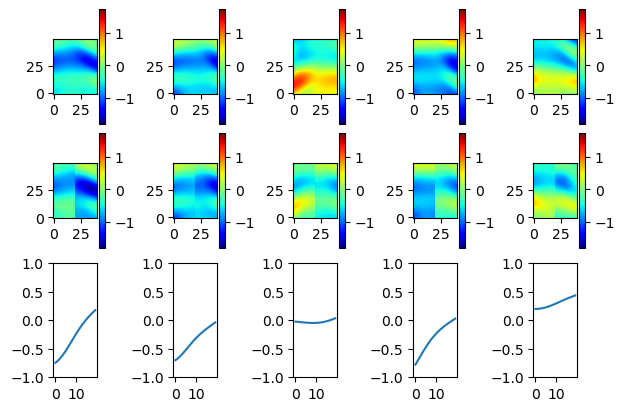

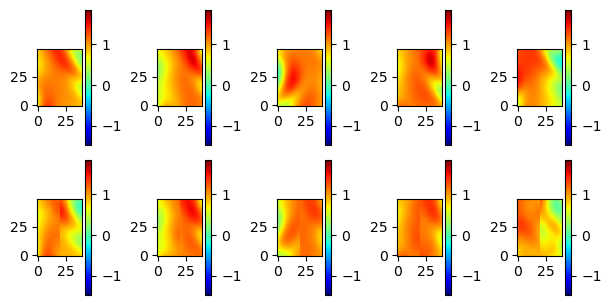

In [256]:
sv5_2_pred1 = mdl5_2.apply(beststate5_2.params, None, data[:,20:40,0,2])
sv5_2_pred_all = jnp.concatenate((sv5_2_pred,sv5_2_pred1),axis=1)
vmax = np.max(sv5,axis=(0,1,2))
vmin = np.min(sv5,axis=(0,1,2))
fig,axes = plt.subplots(3,5,figsize=(6,4))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(sv5[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_2_pred_all[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    plt.colorbar(im1)
    axes[2,i].plot(np.arange(20),sp[t,:])
    axes[2,i].set_ylim(-1,1)
plt.show()
fig,axes = plt.subplots(2,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(sv5[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_2_pred_all[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    plt.colorbar(im1)
plt.show()

## Now add pressure

In [201]:
sp5 = data[:,:40,0,2]
svp5 = data[:,:40,:50,:]

In [257]:
def forward5_3(x):
    mdl1 = MLP(
        [128,20*50, 20*50*2],
        activation=jnp.tanh,
        name='pretrain',
    )
    mdl2 = MLP(
        [128,20*50],
        name='mdl2',
        activation=jnp.tanh,
    )
    cnn1 = hk.Conv2D(8,3)
    cnn2 = hk.Conv2D(3,5)
    act = jnp.tanh

    def strip(x1):
        y1 = mdl1(x1, TRAINING=True).reshape((-1,20,50,2))
        y2 = mdl2(x1, TRAINING=True).reshape((-1,20,50,1))
        y3 = jnp.concatenate((y1,y2), axis=-1)
        # y3 = act(y3)
        # y3 = cnn1(y3)
        # y3 = act(y3)
        # y3 = cnn2(y3)
        return y3
    
    out1 = strip(x[:,:20])
    out2 = strip(x[:,20:])
    return out1,jnp.concatenate((out1,out2), axis=1)
mdl5_3 = hk.transform(forward5_3)
params5_3 = mdl5_3.init(key, sp5[:10,...])

In [258]:
print(jax.tree_map(lambda l: print(l.shape), params5_3))
print(jax.tree_map(lambda l: print(l.shape), params5_2))

(128,)
(20, 128)
(1000,)
(128, 1000)
(128,)
(20, 128)
(1000,)
(128, 1000)
(2000,)
(1000, 2000)
{'mdl2/~/linear_0': {'b': None, 'w': None}, 'mdl2/~/linear_1': {'b': None, 'w': None}, 'pretrain/~/linear_0': {'b': None, 'w': None}, 'pretrain/~/linear_1': {'b': None, 'w': None}, 'pretrain/~/linear_2': {'b': None, 'w': None}}
(128,)
(20, 128)
(1000,)
(128, 1000)
(2000,)
(1000, 2000)
{'pretrain/~/linear_0': {'b': None, 'w': None}, 'pretrain/~/linear_1': {'b': None, 'w': None}, 'pretrain/~/linear_2': {'b': None, 'w': None}}


In [259]:
params5_3_pretrained = {}
for k,v in params5_3.items():
    if k in beststate5_2.params.keys():
        params5_3_pretrained.update({k:beststate5_2.params[k]})
        print('reuse')
    else:
        params5_3_pretrained.update({k:v})
print(jax.tree_map(lambda l: print(l.shape), params5_3_pretrained))

reuse
reuse
reuse
(128,)
(20, 128)
(1000,)
(128, 1000)
(128,)
(20, 128)
(1000,)
(128, 1000)
(2000,)
(1000, 2000)
{'mdl2/~/linear_0': {'b': None, 'w': None}, 'mdl2/~/linear_1': {'b': None, 'w': None}, 'pretrain/~/linear_0': {'b': None, 'w': None}, 'pretrain/~/linear_1': {'b': None, 'w': None}, 'pretrain/~/linear_2': {'b': None, 'w': None}}


In [260]:
jnp.allclose(params5_3_pretrained['pretrain/~/linear_0']['w'], beststate5_2.params['pretrain/~/linear_0']['w'])

Array(True, dtype=bool)

In [261]:
op5_3 = optax.adamw(0.001)
op5_3_state = op5_3.init(params5_3_pretrained)
state5_3 = train.TrainingState(opt_state=op5_3_state, params=params5_3_pretrained)

In [319]:
f = kolsol_forcing_term(4, 128, 2)[:,:,:40,:50]

# def myloss5_1(apply_fn, params, rng, x, y):
#     out1, out2 = apply_fn(params, rng, x)
#     lplane = losses.mse(out1[:,:,:,0], y[:,:20,:,0]) # plane u
#     lbp = losses.mse(out2[:,:20,0,2],y[:,:20,0,2]) + losses.mse(out2[:,40:,0,2],y[:,40:,0,2]) # boundary pressure
#     _ld = losses.divergence(out2[...,:2],datainfo)
#     _lm = losses.momentum_loss(out2,datainfo,forcing=f)
#     lp = _ld + _lm
#     a = 0.9
#     b = 0.03
#     return a*lplane+b*lbp+(1-a-b)*lp, {'plane':lplane, 'boundary':lbp, 'physics':lp}

def myloss5_1(apply_fn, params, rng, x, y):
    out1, out2 = apply_fn(params, rng, x)
    # print(x.shape, out2.shape, y.shape)
    lplane = losses.mse(out1[:,:,:,0], y[:,:20,:,0])
    lplane = lplane + losses.mse(out1[:,:,:,1], y[:,:20,:,1])
    out2 = out2.at[:,:20,:,0].set(y[:,:20,:,0]) # u1
    out2 = out2.at[:,:20,:,1].set(y[:,:20,:,1]) # u2 at the plane
    # out2 = out2.at[:,:20,:,2].set(y[:,:20,:,2]) # pressure at the plane
    # out2 = out2.at[:,::2,::2,:].set(y[:,::2,::2,:])
    out2 = out2.at[:,:,0,2].set(y[:,:,0,2]) # boundary pressure

    l_seam = losses.mse(out1[:,-1,:,:],out2[:,20,:,:])

    _ld = losses.divergence(out2[...,:2],datainfo)
    _lm = losses.momentum_loss(out2,datainfo,forcing=f)
    lp = _ld + _lm
    a = 0.95
    return a*lplane + (1-a)*lp + l_seam, {'plane':lplane, 'physics':lp}

In [357]:
op5_3 = optax.adamw(0.00008)
op5_3_state = op5_3.init(beststate.params)
state5_3 = train.TrainingState(opt_state=op5_3_state, params=beststate.params)

In [358]:
update5_3 = train.generate_update_fn(mdl5_3.apply, op5_3, myloss5_1, kwargs_value_and_grad={'has_aux':True})
# (l,lb),_ = update5_3(state5_3, key, sp5[:10,...], svp5[:10,...])
sv5_3_mid, sv5_3_pred = mdl5_3.apply(state5_3.params, key, sp5)
print(losses.relative_error(pred=sv5_3_pred, true=svp5))

0.50068265


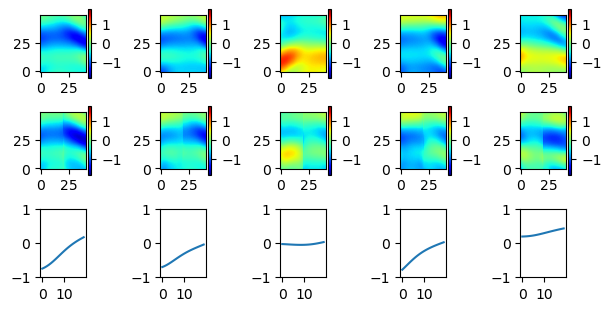

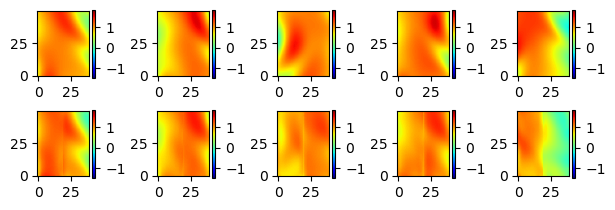

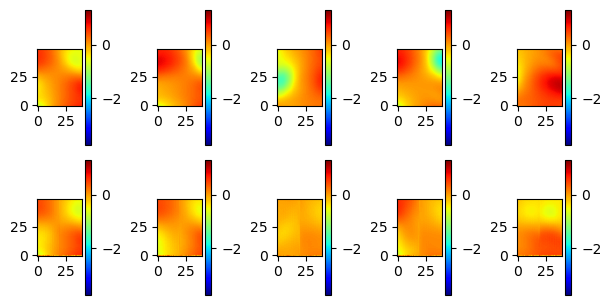

In [359]:
vmax = np.max(sv5,axis=(0,1,2))
vmin = np.min(sv5,axis=(0,1,2))
fig,axes = plt.subplots(3,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(svp5[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_3_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    plt.colorbar(im1)
    axes[2,i].plot(np.arange(20),sp[t,:])
    axes[2,i].set_ylim(-1,1)
plt.show()
fig,axes = plt.subplots(2,5,figsize=(6,2))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(svp5[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_3_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    plt.colorbar(im1)
fig,axes = plt.subplots(2,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(svp5[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_3_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    plt.colorbar(im1)
plt.show()

In [360]:
nb_batches = 100
nperbatch = int(nt/nb_batches)
hist = []

100
0 0.23910633 {'physics': Array(0.57879895, dtype=float32), 'plane': Array(0.02548826, dtype=float32)}
50 0.23565406 {'physics': Array(0.5890342, dtype=float32), 'plane': Array(0.02210684, dtype=float32)}
100 0.23465566 {'physics': Array(0.47638056, dtype=float32), 'plane': Array(0.0217544, dtype=float32)}
150 0.23686895 {'physics': Array(0.61743236, dtype=float32), 'plane': Array(0.02184423, dtype=float32)}
200 0.23645025 {'physics': Array(0.61704755, dtype=float32), 'plane': Array(0.02201732, dtype=float32)}
250 0.23420572 {'physics': Array(0.50929123, dtype=float32), 'plane': Array(0.02196808, dtype=float32)}
300 0.23743638 {'physics': Array(0.6768237, dtype=float32), 'plane': Array(0.02172892, dtype=float32)}
350 0.23546894 {'physics': Array(0.5586213, dtype=float32), 'plane': Array(0.02207184, dtype=float32)}
400 0.23496868 {'physics': Array(0.5802224, dtype=float32), 'plane': Array(0.02205915, dtype=float32)}
450 0.23433161 {'physics': Array(0.55941623, dtype=float32), 'plane'

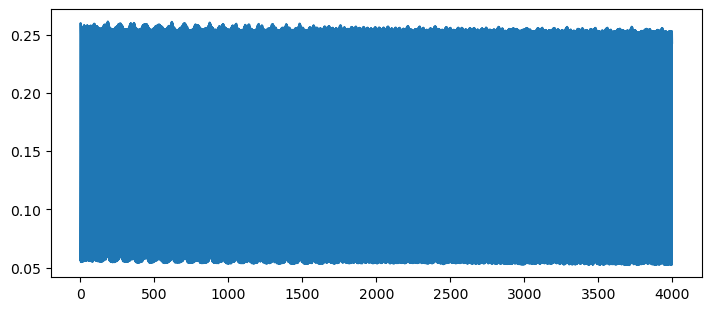

In [361]:
bestloss = jnp.inf
print(nperbatch)
for i in range(1000):
    [key] = jax.random.split(key,1)
    lb = []
    lb_dict = []
    for b in range(nb_batches):
        (l,ld), state5_3 = update5_3(state5_3, key, sp5[b*nperbatch:(b+1)*nperbatch,...], sv5[b*nperbatch:(b+1)*nperbatch,...])
        lb.append(l)
        lb_dict.append(ld)
        hist.append(np.mean(lb))
    if np.mean(lb) < bestloss:
        bestloss = np.mean(lb)
        beststate = state5_3
    if i%50 == 0:
        print(i, np.mean(lb), lb_dict[10])
sv5_mid, sv5_3_pred = mdl5_3.apply(beststate.params, key, sp5)
print(losses.relative_error(pred=sv5_3_pred, true=sv5))
plt.figure(figsize=(7,3))
plt.plot(hist[::25])
plt.show()

In [362]:

# sv5_mid, sv5_3_pred = mdl5_3.apply(beststate.params, key, sp5)

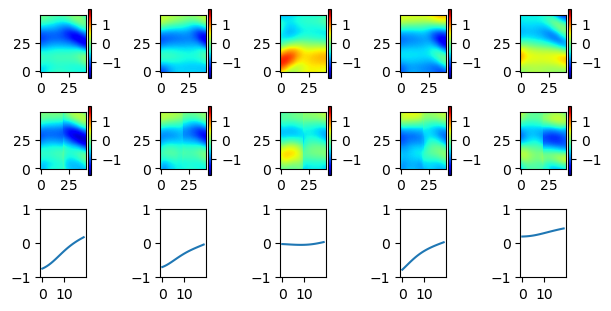

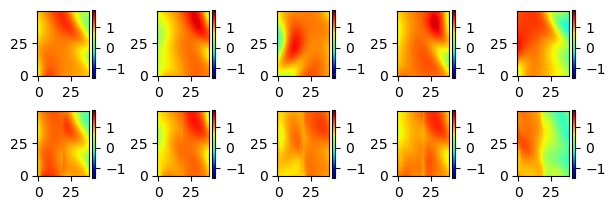

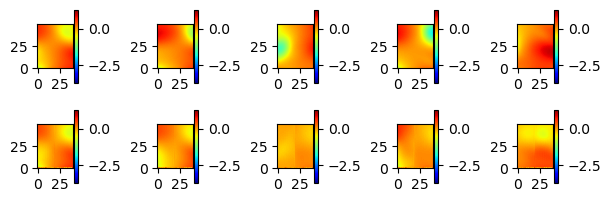

In [363]:
vmax = np.max(sv5,axis=(0,1,2))
vmin = np.min(sv5,axis=(0,1,2))
fig,axes = plt.subplots(3,5,figsize=(6,3))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(sv5[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_3_pred[t,:,:,0].T,origin='lower',vmax=vmax[0], vmin=vmin[0])
    plt.colorbar(im1)
    axes[2,i].plot(np.arange(20),sp[t,:])
    axes[2,i].set_ylim(-1,1)
plt.show()
fig,axes = plt.subplots(2,5,figsize=(6,2))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(sv5[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_3_pred[t,:,:,1].T,origin='lower',vmax=vmax[1], vmin=vmin[1])
    plt.colorbar(im1)
fig,axes = plt.subplots(2,5,figsize=(6,2))
for i,t in enumerate([0,200,2000,5000,9000]):
    im0 = axes[0,i].imshow(sv5[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    plt.colorbar(im0)
    im1 = axes[1,i].imshow(sv5_3_pred[t,:,:,2].T,origin='lower',vmax=vmax[2], vmin=vmin[2])
    plt.colorbar(im1)
plt.show()